# **Audio Data Classification**

We will use a pipeline to read and process a set of files. We can use the same pipeline as the training dataset in keras 

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install keras-nlp --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 35.3 MB/s eta 0:00:00


In [ ]:
# Importing Libraries
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from keras import layers
import keras_nlp
import pandas as pd
import seaborn as sns

We can use the api, ```tf.data.Dataset```, to create a pipeline to read and process files using the function 'map':
https://www.tensorflow.org/guide/data
,
https://www.tensorflow.org/guide/data_performance


We can use directly the ```tf.data.Dataset``` in the keras model fit method. It is a very efficient way to train a model: https://www.tensorflow.org/guide/keras/train_and_evaluate#training_evaluation_from_tfdata_datasets

Next we will exemplify the use of this api in a set of wav files. We can also use the tf.data.Dataset api to create 'batches' that can be used as inputs e labels to a keras model that classifies sounds.

---
# **Data Preparation**

In [ ]:
label_name = [
"air_conditioner",
"car_horn",
"children_playing",
"dog_bark",
"drilling",
"engine_idling",
"gun_shot",
"jackhammer",
"siren",
"street_music"]

In [ ]:
# directory path
dir_train = '/content/drive/MyDrive/trainval_1_2_3_4/'
dir_val = '/content/drive/MyDrive/trainval5/'
dir_test = '/content/drive/MyDrive/test/'


# data source
list_wav_files_train = glob.glob(dir_train + '*.wav')
list_wav_files_val = glob.glob(dir_val + '*.wav')  
list_wav_files_test = glob.glob(dir_test + '*.wav')

# dataset object  -> is a Python iterable
fnames_train = tf.data.Dataset.from_tensor_slices(list_wav_files_train) 
fnames_val = tf.data.Dataset.from_tensor_slices(list_wav_files_val)
fnames_test = tf.data.Dataset.from_tensor_slices(list_wav_files_test)

Using the initial dataset we can create another with the contents of the previous dataset elements (wav files).

We start with a function that reads the contents of a wav file into a tensor and use this function in the 'map' method.

In [ ]:
@tf.function
def load_wav_8k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    wav = tf.math.l2_normalize(wav, axis=0)
    l = tf.shape(wav)[0] 
    if  l < 10000:
        wav = tf.pad(wav, [[0, 10000 - l]])
        
    return wav

In [ ]:
def get_label(wavFname):
    baseName = tf.strings.split(wavFname, sep='/')[-1]
    classLabel = tf.strings.split(baseName, sep='-')[1]
    return int(classLabel)

We could also use the 'map' method to produce a dataset containg 'tuples', (input, target)

In [ ]:
train_1 = fnames_train.map(lambda x: (load_wav_8k_mono(x), get_label(x)))
val_1 = fnames_val.map(lambda x: (load_wav_8k_mono(x), get_label(x)))
test_1 = fnames_test.map(lambda x: (load_wav_8k_mono(x), get_label(x)))

In [ ]:
it = iter(train_1)
ex = next(it)
ex

(<tf.Tensor: shape=(32000,), dtype=float32, numpy=
 array([ 1.3188161e-03,  6.4656246e-03,  4.8299502e-03, ...,
        -4.2818705e-05, -2.2437002e-03, -1.4044535e-03], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=int32, numpy=2>)

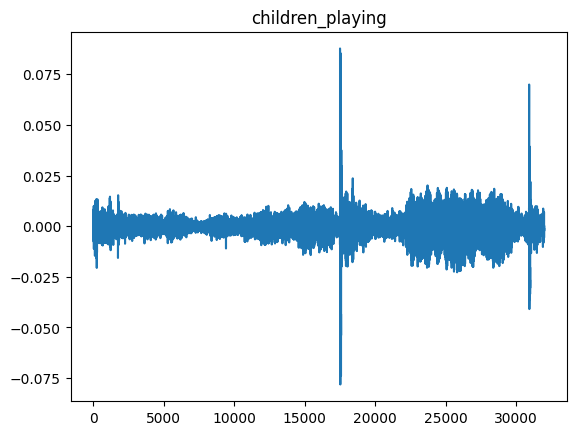

In [ ]:
plt.plot(ex[0])
plt.title(label_name[int(ex[1])])
plt.show()

In [ ]:
# padded batch dataset with batch size = 256
batch_size = 256
train_256 = train_1.padded_batch(batch_size, padded_shapes=([None,],[]))
val_256 = val_1.padded_batch(batch_size, padded_shapes=([None,],[]))
test_256 = test_1.padded_batch(batch_size, padded_shapes=([None,],[]))

**Counting the labels of the training set**

In [ ]:
label_counts = {}

for data in train_256:
    unique_labels, idx, label_counts_batch = tf.unique_with_counts(labels)
    
    for label, count in zip(unique_labels.numpy(), label_counts_batch.numpy()):
        label_counts[label] = label_counts.get(label, 0) + count

print(label_counts)

{7: 600, 4: 725, 2: 925, 9: 750, 0: 475, 3: 875, 5: 725, 1: 300, 8: 800, 6: 225}


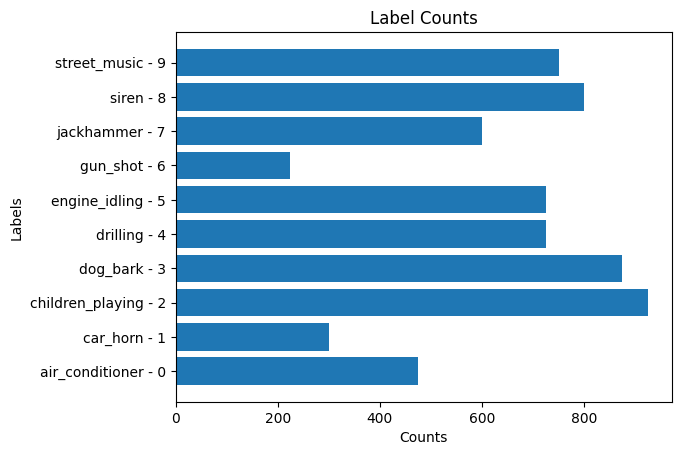

In [ ]:
label = list(label_counts.keys())
counts = list(label_counts.values())
label_name1 = [label_name[i]+f" - {i}" for i in label] 

plt.barh(label, counts, tick_label=label_name1)
plt.xlabel('Counts')
plt.ylabel('Labels')
plt.title('Label Counts')
plt.show()

---
  ## **STFT - Short-Time Fourier Transform**

  https://www.tensorflow.org/api_docs/python/tf/signal/stft
  
  https://www.tensorflow.org/tutorials/audio/simple_audio#convert_waveforms_to_spectrograms

  **STFT** divides the signal into overlapping frames of a specified length, applies a window function to each frame, and computes the discrete Fourier transform (DFT) of each windowed frame.


  - ```frame_length```: length of the frames.
  - ```frame_step```: amount of overlap between adjacent frames.

- The **frame_length** determines the size of the window used for each frame in the STFT calculation. A larger frame_length provides more frequency resolution but less time resolution. On the other hand, a smaller frame_length gives better time resolution but less frequency resolution.

- The **frame_step** parameter determines the overlap between consecutive frames. A smaller frame_step value results in more overlap between frames, providing smoother transitions in the STFT representation but with a higher computational cost. Conversely, a larger frame_step value reduces the overlap, resulting in less smoothness but faster computation.

In [ ]:
spectrogram = tf.signal.stft(ex[0], frame_length=128, frame_step=64)
spectrogram = tf.abs(spectrogram)
spectrogram = spectrogram[..., tf.newaxis]
spectrogram.shape

TensorShape([499, 65, 1])

In [ ]:
def plot_spectrogram(spectrogram):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  plt.pcolormesh(X, Y, log_spec)

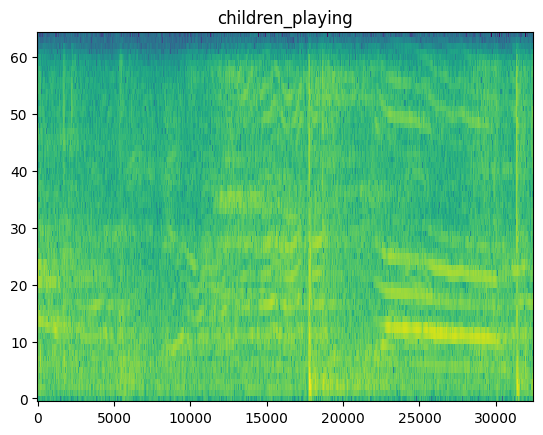

In [ ]:
plot_spectrogram(spectrogram.numpy())
plt.title(label_name[int(ex[1])])
plt.show()

  We could also use the ```.map()``` method to apply the **STFT** to the dataset inputs.

In [ ]:
# Train with Short Time Fourier Transform
train_stft = train_1.map(lambda x, y: (tf.abs(tf.signal.stft(x, frame_length=128, frame_step=64)), y))
val_stft = val_1.map(lambda x, y: (tf.abs(tf.signal.stft(x, frame_length=128, frame_step=64)), y))
test_stft = test_1.map(lambda x, y: (tf.abs(tf.signal.stft(x, frame_length=128, frame_step=64)), y))

# Padded Batch dataset
batch_size = 256
train_stft_256 = train_stft.padded_batch(batch_size, padded_shapes=([None, 65],[]))
val_stft_256 = val_stft.padded_batch(batch_size, padded_shapes=([None, 65],[]))
test_stft_256 = test_stft.padded_batch(batch_size, padded_shapes=([None, 65],[]))

---
**Training plot function**

In [ ]:
# Training plot
def training_plot(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)

  fig, axes = plt.subplots(1, 2, figsize=(9, 4.5), tight_layout=True)

  # Training and validation loss
  axes[0].plot(epochs, loss, label='Training loss', color='royalblue')
  axes[0].plot(epochs, val_loss, label='Validation loss', color='darkorange')
  axes[0].set_title('Training and Validation Loss')
  axes[0].set_xlabel('Epochs')
  axes[0].legend()
  
  # Training and validation accuracy
  axes[1].plot(epochs, acc, label='Training acc', color='royalblue')
  axes[1].plot(epochs, val_acc, label='Validation acc', color='darkorange')
  axes[1].set_title('Training and Validation Accuracy')
  axes[1].set_xlabel('Epochs')
  axes[1].legend()
  
  plt.show()

---
#  **1) CNN - Convolutional Neural Network**

- **Filters size**: when CNNs are applied to sequential data, such as text or time series data, the typical structure is different from when CNNs are applied to image data. Instead of having convolutional layers with increasing numbers of filters, the convolutional layers in CNNs for sequential data typically have a **fixed number of filters**. Additionally the number of filters may be **higher** than in other types of sequential data, such as NLP tasks, because sound data can have more complex patterns and features to capture.

- **Kernel size**: the convolutional layers may have larger kernel sizes, such as 10 or 20, to capture patterns in the sound that occur over longer time periods.

- **Pool size**: A common choice for pool size in CNNs for sound data is a pool size of 2 or 4, which reduces the dimensionality of the feature maps by a factor of 2 or 4, respectively. However, larger or smaller pool sizes may also be used depending on the specific task and the size of the input data.

- **Spatial dropout**: instead of dropping individual neurons, entire channels (feature maps) of the convolutional layer are randomly dropped out during each training iteration. This encourages the network to learn more robust features by forcing it to use different combinations of feature maps for each training example.



## **1.1) CNN on waveforms**

In [ ]:
inputs = keras.Input(shape=[None,])
reshaped = layers.Reshape((-1,1))(inputs)
normalization = layers.Normalization()(reshaped)

conv1 = layers.Conv1D(64, 5, activation="elu", padding="same", kernel_initializer='HeNormal')(normalization)
pool1 = layers.MaxPooling1D(pool_size=4)(conv1)
spatial_dropout1 = layers.SpatialDropout1D(rate=0.5)(pool1)

conv2 = layers.Conv1D(64, 10, activation="elu", padding="same", kernel_initializer='HeNormal')(spatial_dropout1)
pool2 = layers.MaxPooling1D(pool_size=4)(conv2)
spatial_dropout2 = layers.SpatialDropout1D(rate=0.5)(pool2)

conv3 = layers.Conv1D(64, 15, activation="elu", padding="same", kernel_initializer='HeNormal')(spatial_dropout2)
pool3 = layers.MaxPooling1D(pool_size=4)(conv3)
spatial_dropout3 = layers.SpatialDropout1D(rate=0.5)(pool3)

conv4 = layers.Conv1D(64, 20, activation="elu", padding="same", kernel_initializer='HeNormal')(spatial_dropout3)
pool4 = layers.GlobalMaxPooling1D()(conv4)
dropout1 = layers.Dropout(rate=0.3)(pool4)

dense = layers.Dense(128, activation="elu", kernel_initializer='HeNormal')(dropout1)
dropout2 = layers.Dropout(rate=0.3)(dense)
outputs = layers.Dense(10)(dropout2)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 reshape (Reshape)           (None, None, 1)           0         
                                                                 
 normalization (Normalizatio  (None, None, 1)          3         
 n)                                                              
                                                                 
 conv1d (Conv1D)             (None, None, 64)          384       
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 64)         0         
 )                                                               
                                                                 
 spatial_dropout1d (SpatialD  (None, None, 64)         0     

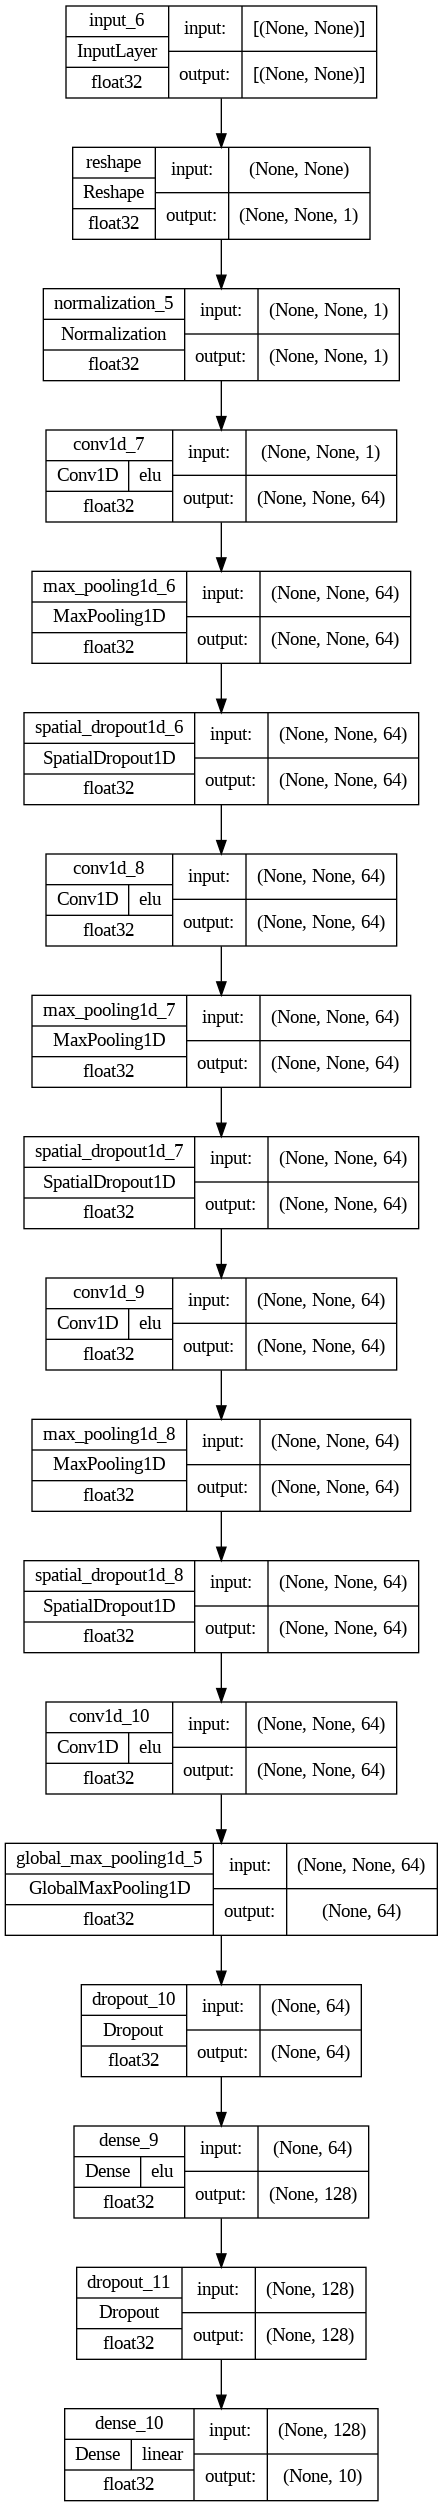

In [ ]:
# Plot Model Architecture
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    show_layer_activations=True)

In [ ]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Fit the model
history_cnn = model.fit(train_256, 
                        validation_data = val_256, 
                        epochs=50)

Epoch 1/50
25/25 [==============================] - 38s 1s/step - loss: 2.2029 - accuracy: 0.1787 - val_loss: 2.1488 - val_accuracy: 0.2298
Epoch 2/50
25/25 [==============================] - 18s 703ms/step - loss: 1.9662 - accuracy: 0.2806 - val_loss: 1.9994 - val_accuracy: 0.2635
Epoch 3/50
25/25 [==============================] - 18s 707ms/step - loss: 1.8277 - accuracy: 0.3472 - val_loss: 1.9048 - val_accuracy: 0.3444
Epoch 4/50
25/25 [==============================] - 19s 728ms/step - loss: 1.7125 - accuracy: 0.3877 - val_loss: 1.8402 - val_accuracy: 0.3953
Epoch 5/50
25/25 [==============================] - 18s 698ms/step - loss: 1.6531 - accuracy: 0.4104 - val_loss: 1.8327 - val_accuracy: 0.4061
Epoch 6/50
25/25 [==============================] - 18s 705ms/step - loss: 1.5668 - accuracy: 0.4431 - val_loss: 1.8140 - val_accuracy: 0.4208
Epoch 7/50
25/25 [==============================] - 18s 694ms/step - loss: 1.5497 - accuracy: 0.4406 - val_loss: 1.7601 - val_accuracy: 0.4488
Ep

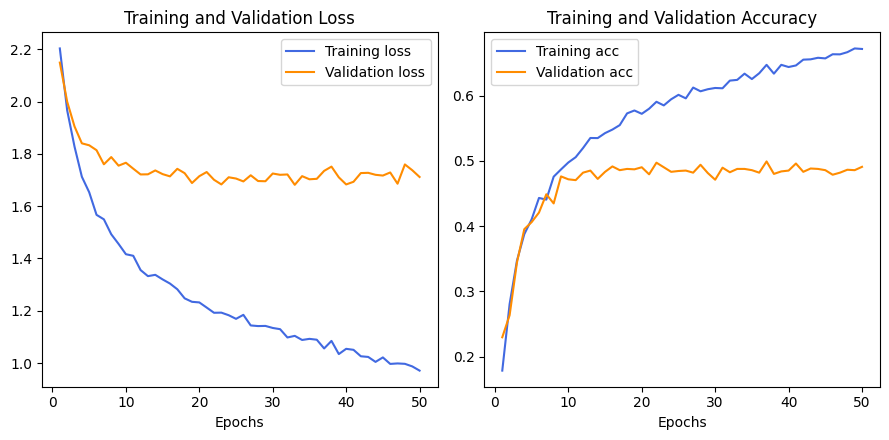

In [ ]:
training_plot(history_cnn)

In [ ]:
# Model Evaluation on the test set
results = model.evaluate(test_256)
print(f"test loss: {results[0]}, test acc: {results[1]}")

2/2 [==============================] - 3s 2s/step - loss: 0.9941 - accuracy: 0.6170
test loss: 0.994071900844574, test acc: 0.6169725060462952


2/2 [==============================] - 1s 306ms/step


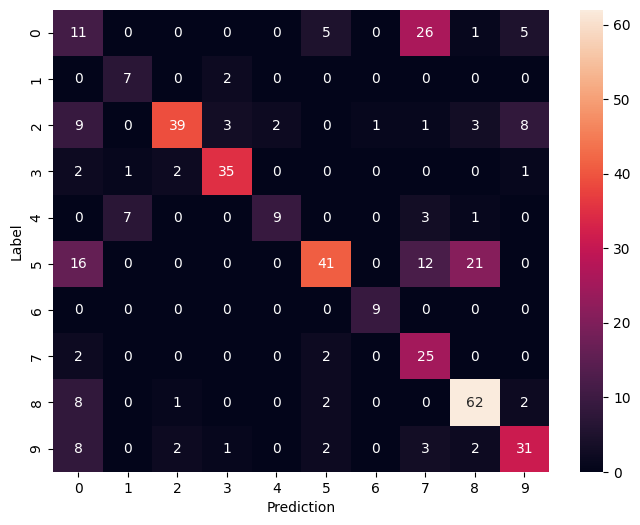

In [ ]:
# Confusion matrix
y_pred = model.predict(test_256)
y_pred = tf.argmax(y_pred, axis=1)

y_true = tf.concat(list(test_256.map(lambda w,lab: lab)), axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
# Save weights of the model
model.save_weights("CNN_waveforms.h5")

---

## **1.2) CNN on stft** 

In [ ]:
inputs = keras.Input(shape=(None, 65))
normalization = layers.Normalization()(inputs)

conv1 = layers.Conv1D(128, 3, activation="elu", padding="same", kernel_initializer='HeNormal')(normalization)
pool1 = layers.MaxPooling1D(pool_size=2)(conv1)
spatial_dropout1 = layers.SpatialDropout1D(rate=0.4)(pool1)
                                                                              
conv2 = layers.Conv1D(128, 3, activation="elu", padding="same", kernel_initializer='HeNormal')(spatial_dropout1)
pool2 = layers.MaxPooling1D(pool_size=2)(conv2)
spatial_dropout2 = layers.SpatialDropout1D(rate=0.4)(pool2)

conv3 = layers.Conv1D(128, 3, activation="elu", padding="same", kernel_initializer='HeNormal')(spatial_dropout2)
pool3 = layers.GlobalMaxPooling1D()(conv3)
dropout1 = layers.Dropout(rate=0.3)(pool3)

dense = layers.Dense(128, activation="elu", kernel_initializer='HeNormal')(dropout1)
dropout2 = layers.Dropout(rate=0.3)(dense)
outputs = layers.Dense(10)(dropout2)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, 65)]        0         
                                                                 
 normalization_4 (Normalizat  (None, None, 65)         131       
 ion)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, None, 128)         25088     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, None, 128)        0         
 1D)                                                             
                                                                 
 spatial_dropout1d_4 (Spatia  (None, None, 128)        0         
 lDropout1D)                                                     
                                                           

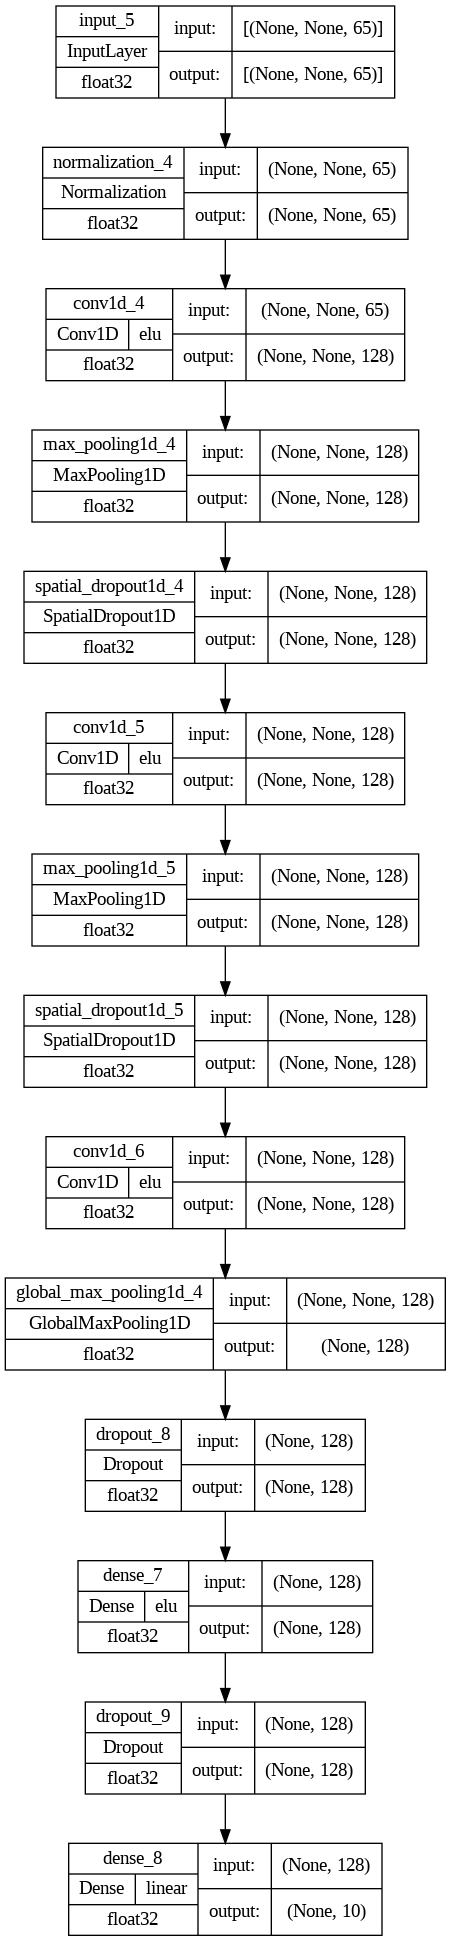

In [ ]:
# Plot Model Architecture
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    show_layer_activations=True)

In [ ]:
# Compile the model
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Fit the model
history_cnn = model.fit(train_stft_256, 
                        validation_data=val_stft_256, 
                        epochs=100)

Epoch 1/100
25/25 [==============================] - 28s 962ms/step - loss: 2.1473 - accuracy: 0.2288 - val_loss: 1.9423 - val_accuracy: 0.4010
Epoch 2/100
25/25 [==============================] - 22s 885ms/step - loss: 1.7366 - accuracy: 0.3810 - val_loss: 1.8890 - val_accuracy: 0.3991
Epoch 3/100
25/25 [==============================] - 22s 868ms/step - loss: 1.5476 - accuracy: 0.4441 - val_loss: 1.8687 - val_accuracy: 0.4239
Epoch 4/100
25/25 [==============================] - 24s 957ms/step - loss: 1.4508 - accuracy: 0.4862 - val_loss: 1.8365 - val_accuracy: 0.4265
Epoch 5/100
25/25 [==============================] - 23s 913ms/step - loss: 1.3729 - accuracy: 0.5094 - val_loss: 1.7831 - val_accuracy: 0.4354
Epoch 6/100
25/25 [==============================] - 28s 1s/step - loss: 1.3090 - accuracy: 0.5294 - val_loss: 1.8159 - val_accuracy: 0.4367
Epoch 7/100
25/25 [==============================] - 23s 933ms/step - loss: 1.2517 - accuracy: 0.5605 - val_loss: 1.8083 - val_accuracy: 0.

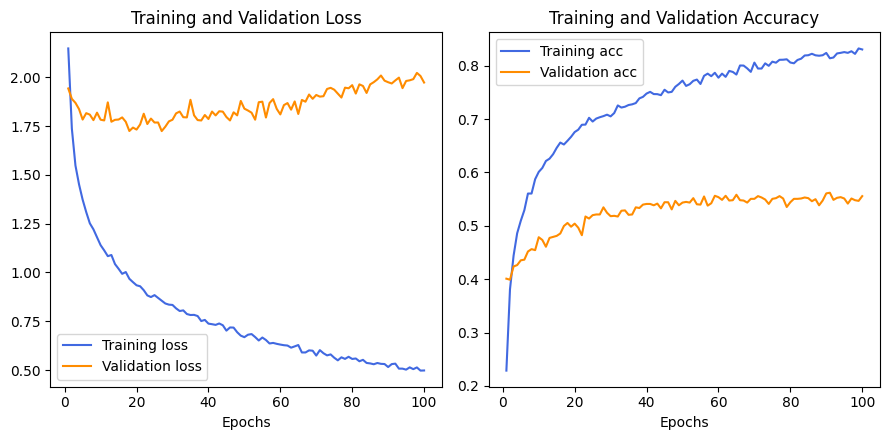

In [ ]:
training_plot(history_cnn)

In [ ]:
# Evaluation on the test set
results = model.evaluate(test_stft_256)
print("test loss, test acc:", results)

2/2 [==============================] - 1s 610ms/step - loss: 0.7311 - accuracy: 0.7408
test loss, test acc: [0.7311305999755859, 0.7408257126808167]


2/2 [==============================] - 1s 462ms/step


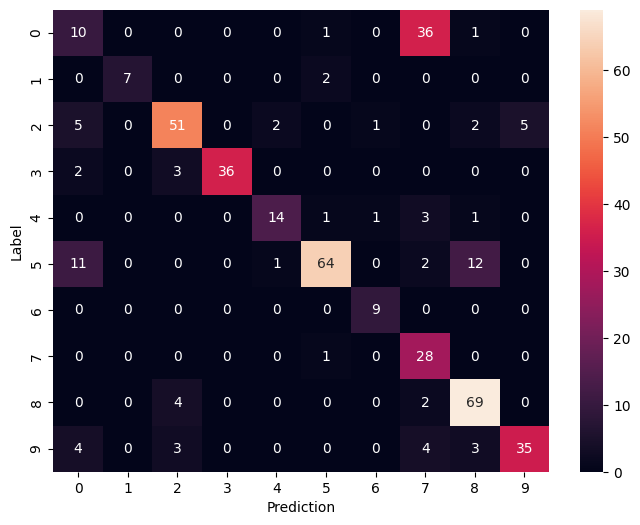

In [ ]:
# Confusion matrix
y_pred = model.predict(test_stft_256)
y_pred = tf.argmax(y_pred, axis=1)

y_true = tf.concat(list(test_stft_256.map(lambda w,lab: lab)), axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
# Save weights of the model
model.save_weights("CNN_stft.h5")

---
# **2) CRNN - Convolutional Recurrent Neural Network**

## **2.1) CRNN on waveforms**

In [ ]:
inputs = keras.Input(shape=[None,])
reshaped = layers.Reshape((-1,1))(inputs)
normalization = layers.Normalization()(reshaped)

conv1 = layers.Conv1D(64, 5, activation="elu", padding="same", kernel_initializer='HeNormal')(normalization)
pool1 = layers.MaxPooling1D(pool_size=4)(conv1)
spatial_dropout1 = layers.SpatialDropout1D(rate=0.5)(pool1)

conv2 = layers.Conv1D(64, 10, activation="elu", padding="same", kernel_initializer='HeNormal')(spatial_dropout1)
pool2 = layers.MaxPooling1D(pool_size=4)(conv2)
spatial_dropout2 = layers.SpatialDropout1D(rate=0.5)(pool2)

conv3 = layers.Conv1D(64, 15, activation="elu", padding="same", kernel_initializer='HeNormal')(spatial_dropout2)
pool3 = layers.MaxPooling1D(pool_size=4)(conv3)
spatial_dropout3 = layers.SpatialDropout1D(rate=0.5)(pool3)

conv4 = layers.Conv1D(64, 20, activation="elu", padding="same", kernel_initializer='HeNormal')(spatial_dropout3)
pool4 = layers.MaxPooling1D(pool_size=4)(conv4)
spatial_dropout4 = layers.SpatialDropout1D(rate=0.5)(pool4)

lstm1 = layers.LSTM(128, return_sequences=True, dropout=0.2)(spatial_dropout4)
lstm2 = layers.LSTM(128, return_sequences=True, dropout=0.2)(lstm1)
global_pool = layers.GlobalMaxPooling1D()(lstm2)

dense = layers.Dense(128, activation="elu", kernel_initializer='HeNormal')(global_pool)
dropout = layers.Dropout(rate=0.3)(dense)
outputs = layers.Dense(10)(dropout)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 reshape_1 (Reshape)         (None, None, 1)           0         
                                                                 
 normalization_1 (Normalizat  (None, None, 1)          3         
 ion)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, None, 64)          384       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, None, 64)         0         
 1D)                                                             
                                                                 
 spatial_dropout1d_4 (Spatia  (None, None, 64)         0   

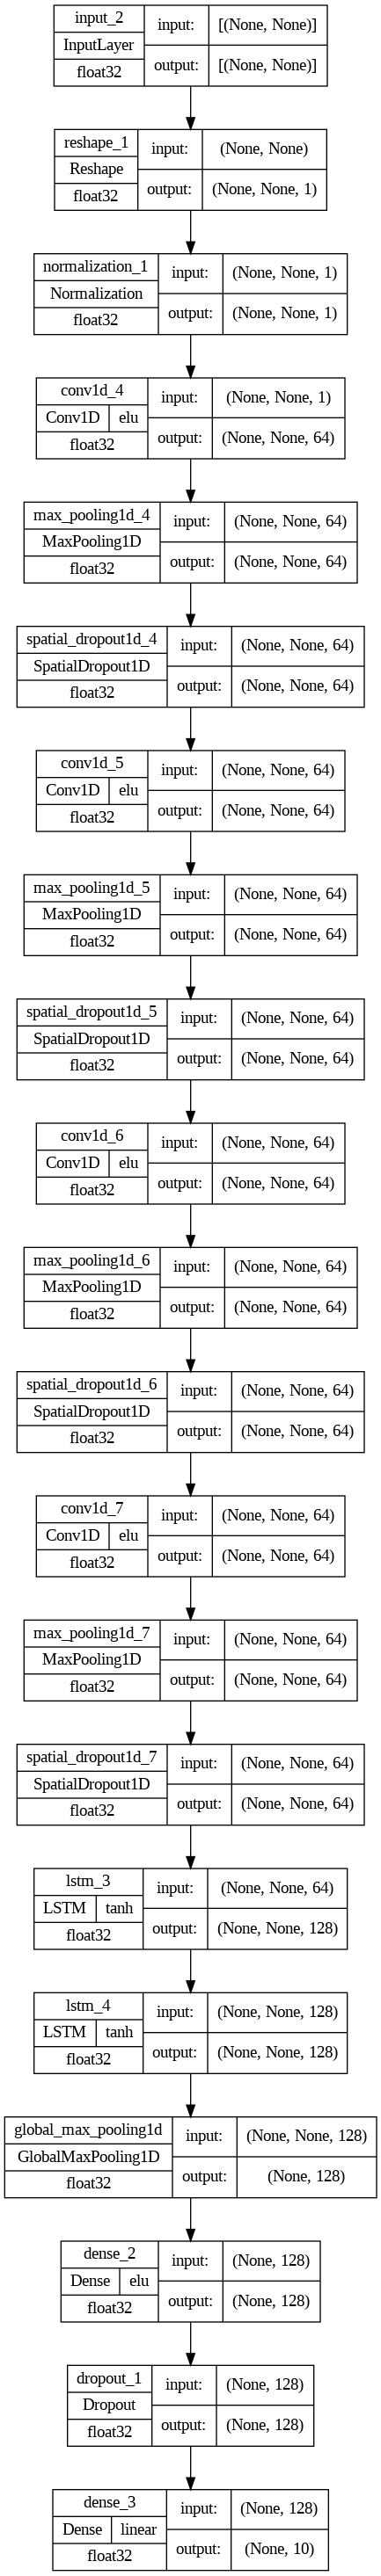

In [ ]:
# Plot Model Architecture
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    show_layer_activations=True)

In [ ]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Fit the model
history_crnn = model.fit(train_256, 
                        epochs=100,
                        validation_data = val_256)

Epoch 1/100
25/25 [==============================] - 26s 783ms/step - loss: 2.1820 - accuracy: 0.1800 - val_loss: 2.1458 - val_accuracy: 0.2374
Epoch 2/100
25/25 [==============================] - 19s 757ms/step - loss: 1.9447 - accuracy: 0.2787 - val_loss: 2.1265 - val_accuracy: 0.2425
Epoch 3/100
25/25 [==============================] - 20s 799ms/step - loss: 1.8165 - accuracy: 0.3304 - val_loss: 2.0403 - val_accuracy: 0.2871
Epoch 4/100
25/25 [==============================] - 19s 762ms/step - loss: 1.7220 - accuracy: 0.3602 - val_loss: 2.0721 - val_accuracy: 0.3043
Epoch 5/100
25/25 [==============================] - 19s 748ms/step - loss: 1.6252 - accuracy: 0.3940 - val_loss: 2.0016 - val_accuracy: 0.3482
Epoch 6/100
25/25 [==============================] - 20s 777ms/step - loss: 1.5480 - accuracy: 0.4303 - val_loss: 1.9860 - val_accuracy: 0.3857
Epoch 7/100
25/25 [==============================] - 19s 751ms/step - loss: 1.4693 - accuracy: 0.4576 - val_loss: 1.9744 - val_accuracy:

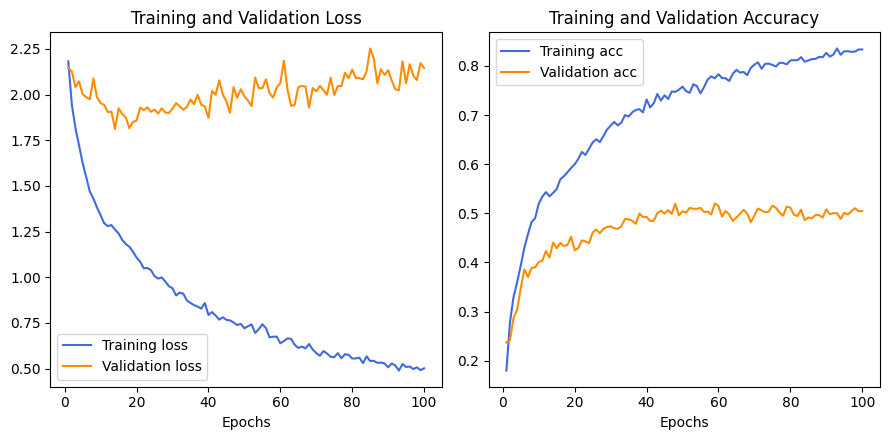

In [ ]:
training_plot(history_crnn)

In [ ]:
# Retrain the model with n. epochs set to the highest validation accuracy

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Fit the model
history_crnn = model.fit(train_256, 
                        epochs=100,
                        validation_data = val_256)

In [ ]:
# Evaluation on the test set
results = model.evaluate(test_256)
print("test loss, test acc:", results)

2/2 [==============================] - 1s 267ms/step - loss: 1.2245 - accuracy: 0.6078
test loss, test acc: [1.2245296239852905, 0.607798159122467]


2/2 [==============================] - 2s 94ms/step


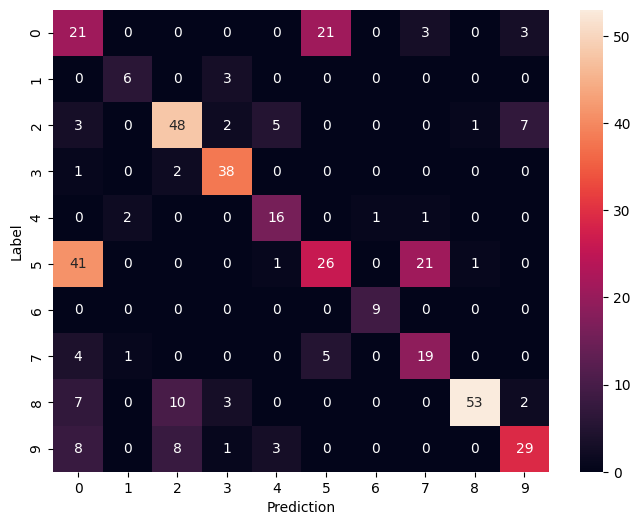

In [ ]:
# Confusion matrix
y_pred = model.predict(test_256)
y_pred = tf.argmax(y_pred, axis=1)

y_true = tf.concat(list(test_256.map(lambda w,lab: lab)), axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
# Save weights of the model
model.save_weights("CRNN_waveform.h5")

## **2.2) CRNN on stft**

In [ ]:
inputs = keras.Input(shape=(None, 65))
normalization = layers.Normalization()(inputs)

conv1 = layers.Conv1D(128, 5, activation="elu", padding="same", kernel_initializer='HeNormal')(normalization)
pool1 = layers.MaxPooling1D(pool_size=2)(conv1)
spatial_dropout1 = layers.SpatialDropout1D(rate=0.3)(pool1)

conv2 = layers.Conv1D(128, 10, activation="elu", padding="same", kernel_initializer='HeNormal')(spatial_dropout1)
pool2 = layers.MaxPooling1D(pool_size=2)(conv2)
spatial_dropout2 = layers.SpatialDropout1D(rate=0.3)(pool2)

lstm1 = layers.LSTM(128, return_sequences=True, dropout=0.2)(spatial_dropout2)
lstm2 = layers.LSTM(128, return_sequences=True, dropout=0.2)(lstm1)
global_pool = layers.GlobalMaxPooling1D()(lstm2)
dropout1 = layers.Dropout(rate=0.3)(global_pool)

dense = layers.Dense(128, activation="elu", kernel_initializer='HeNormal')(dropout1)
dropout2 = layers.Dropout(rate=0.3)(dense)
outputs = layers.Dense(10)(dropout2)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 65)]        0         
                                                                 
 normalization_1 (Normalizat  (None, None, 65)         131       
 ion)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, None, 128)         41728     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, None, 128)        0         
 1D)                                                             
                                                                 
 spatial_dropout1d_2 (Spatia  (None, None, 128)        0         
 lDropout1D)                                                     
                                                           

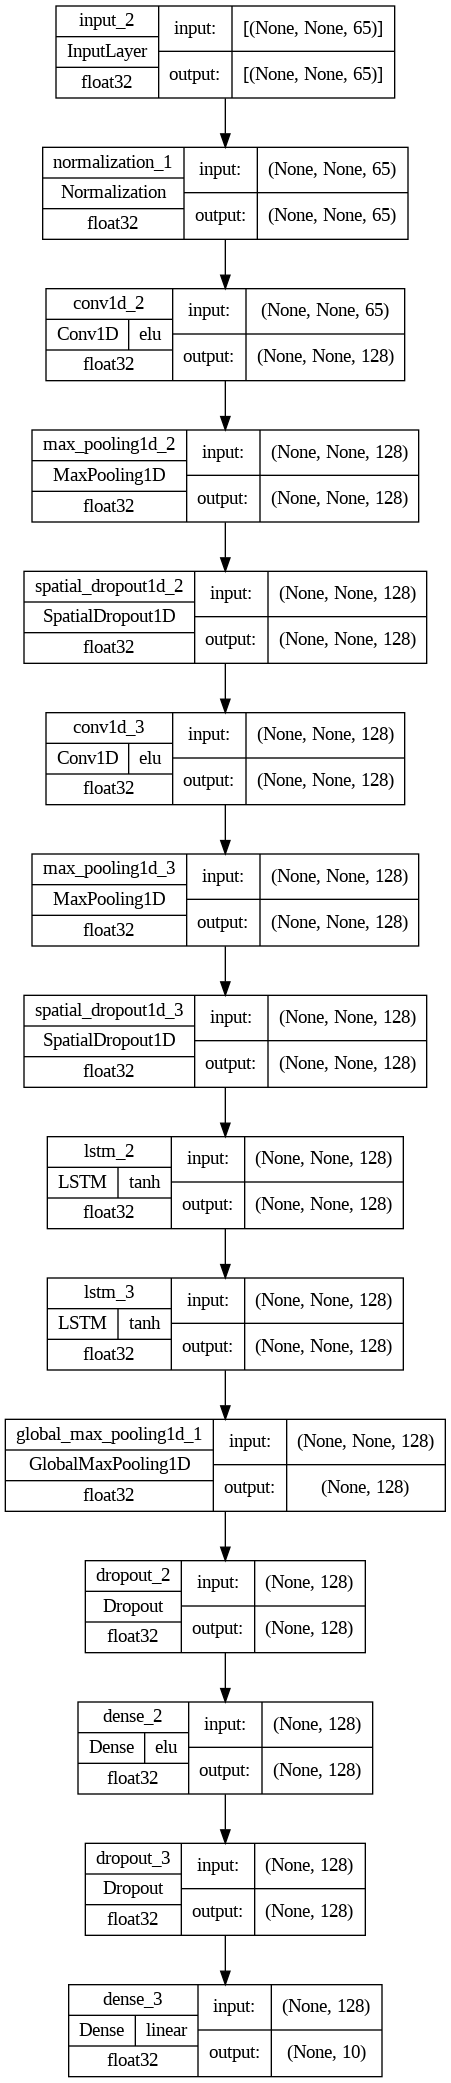

In [ ]:
# Plot Model Architecture
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    show_layer_activations=True)

In [ ]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Fit the model
history_crnn = model.fit(train_stft_256, 
                        epochs=100,
                        validation_data = val_stft_256)

Epoch 1/100
25/25 [==============================] - 3216s 129s/step - loss: 2.0181 - accuracy: 0.2739 - val_loss: 2.0262 - val_accuracy: 0.3106
Epoch 2/100
25/25 [==============================] - 23s 917ms/step - loss: 1.7003 - accuracy: 0.3923 - val_loss: 1.9846 - val_accuracy: 0.3705
Epoch 3/100
25/25 [==============================] - 23s 943ms/step - loss: 1.5305 - accuracy: 0.4534 - val_loss: 1.8822 - val_accuracy: 0.3870
Epoch 4/100
25/25 [==============================] - 23s 937ms/step - loss: 1.3952 - accuracy: 0.5035 - val_loss: 1.9734 - val_accuracy: 0.3826
Epoch 5/100
25/25 [==============================] - 23s 937ms/step - loss: 1.3402 - accuracy: 0.5272 - val_loss: 2.0030 - val_accuracy: 0.3552
Epoch 6/100
25/25 [==============================] - 22s 897ms/step - loss: 1.2900 - accuracy: 0.5534 - val_loss: 1.8315 - val_accuracy: 0.4258
Epoch 7/100
25/25 [==============================] - 23s 919ms/step - loss: 1.1858 - accuracy: 0.5858 - val_loss: 2.1169 - val_accuracy

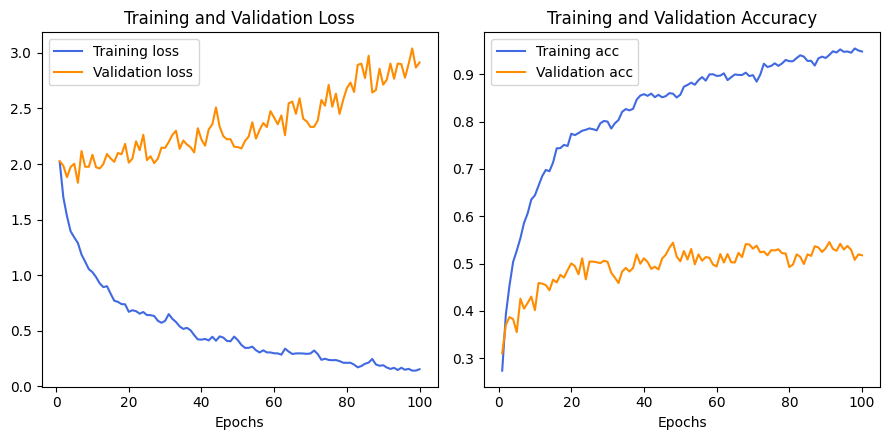

In [ ]:
training_plot(history_crnn)

In [ ]:
# Evaluation on the test set
results = model.evaluate(test_stft_256)
print("test loss, test acc:", results)

2/2 [==============================] - 182s 74s/step - loss: 1.2256 - accuracy: 0.7294
test loss, test acc: [1.225580096244812, 0.7293577790260315]


2/2 [==============================] - 2s 367ms/step


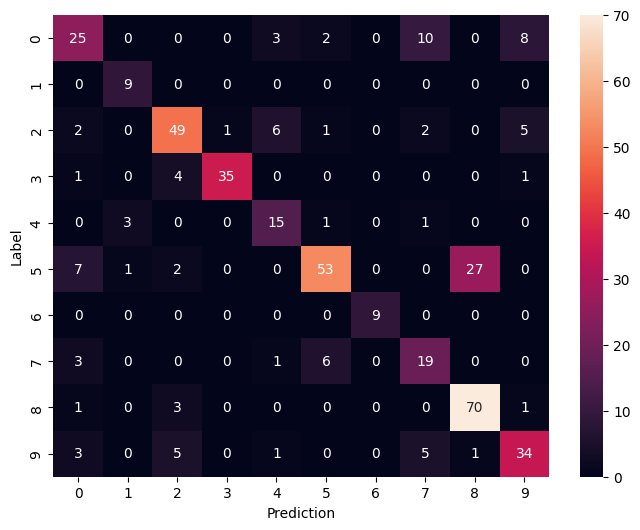

In [ ]:
# Confusion matrix
y_pred = model.predict(test_stft_256)
y_pred = tf.argmax(y_pred, axis=1)

y_true = tf.concat(list(test_stft_256.map(lambda w,lab: lab)), axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
# Save weights of the model
model.save_weights("CRNN_stft.h5")

---
# **3) Transformers**

## **3.1) Transformers on waveforms**

-  ```pool3 + position_embeddings``` is an element wise addiction between pool3 and position_embeddings combines the pooled features with the positional embeddings to create an intermediate representation. This step allows the model to incorporate both local features extracted by convolution and positional information provided by position embedding.

In [ ]:
k = 128
MAX_SEQ_LENGTH = 126 

inputs = keras.Input(shape=[None,])
reshaped = layers.Reshape(target_shape=(-1,1))(inputs)
normalization = layers.Normalization()(reshaped)

conv1 = layers.Conv1D(filters=64, kernel_size=5,  activation='elu', padding="same", kernel_initializer='HeNormal')(normalization)
pool1 = layers.MaxPooling1D(pool_size=4)(conv1)
spatial_dropout1 = layers.SpatialDropout1D(rate=0.3)(pool1)

conv2 = layers.Conv1D(filters=64, kernel_size=10, activation='elu', padding="same", kernel_initializer='HeNormal')(spatial_dropout1)
pool2 = layers.MaxPooling1D(pool_size=4)(conv2)
spatial_dropout2 = layers.SpatialDropout1D(rate=0.3)(pool2)

conv3 = layers.Conv1D(filters=64, kernel_size=15, activation='elu', padding="same", kernel_initializer='HeNormal')(spatial_dropout2 )
pool3 = layers.MaxPooling1D(pool_size=4)(conv3)
spatial_dropout3 = layers.SpatialDropout1D(rate=0.3)(pool3)

conv4 = layers.Conv1D(filters=64, kernel_size=20, activation='elu', padding="same", kernel_initializer='HeNormal')(spatial_dropout3)
pool4 = layers.MaxPooling1D(pool_size=4)(conv4)

position_embeddings = keras_nlp.layers.PositionEmbedding(sequence_length = MAX_SEQ_LENGTH)(pool4)
inter = pool4 + position_embeddings

encoder1 = keras_nlp.layers.TransformerDecoder(intermediate_dim=k, num_heads=8)(inter) # 4
encoder2 = keras_nlp.layers.TransformerDecoder(intermediate_dim=k, num_heads=8)(encoder1)
global_pool = layers.GlobalMaxPooling1D()(encoder2)
dropout = layers.Dropout(rate=0.2)(global_pool) 

outputs = layers.Dense(10)(dropout) 

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 reshape_1 (Reshape)            (None, None, 1)      0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, None, 1)     3           ['reshape_1[0][0]']              
 )                                                                                                
                                                                                                  
 conv1d_4 (Conv1D)              (None, None, 64)     384         ['normalization_1[0][0]']    

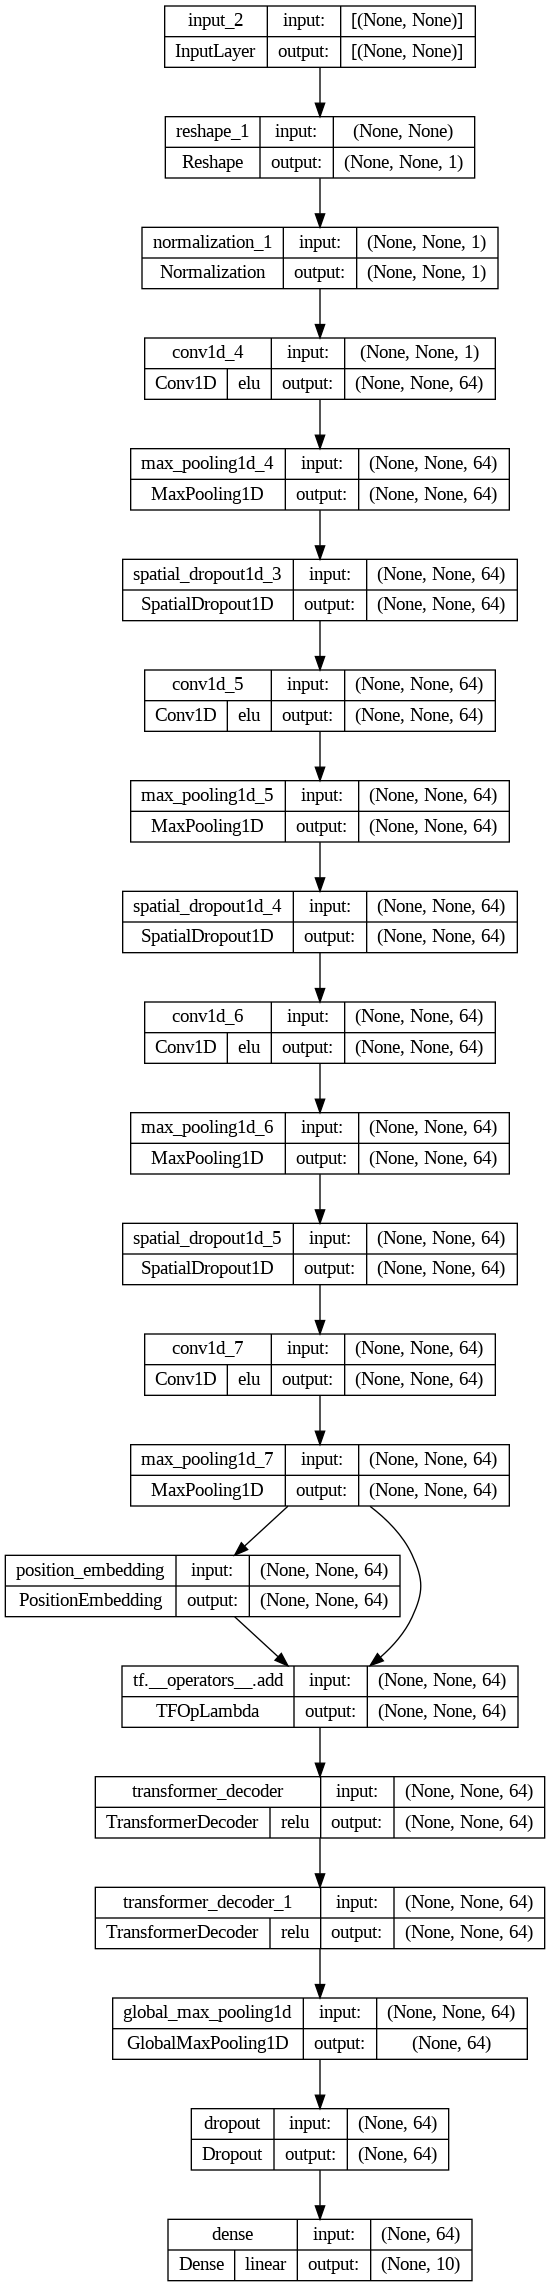

In [ ]:
keras.utils.plot_model(model, 
                       show_shapes=True, 
                       show_layer_activations=True)

In [ ]:
# Compile the model
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Fit the model
history = model.fit(train_256, 
                    validation_data = val_256, 
                    epochs=100)

Epoch 1/100
25/25 [==============================] - 977s 38s/step - loss: 2.7178 - accuracy: 0.1409 - val_loss: 2.1982 - val_accuracy: 0.1489
Epoch 2/100
25/25 [==============================] - 19s 764ms/step - loss: 2.1301 - accuracy: 0.2061 - val_loss: 2.1386 - val_accuracy: 0.2635
Epoch 3/100
25/25 [==============================] - 20s 808ms/step - loss: 1.9385 - accuracy: 0.2791 - val_loss: 2.0701 - val_accuracy: 0.2731
Epoch 4/100
25/25 [==============================] - 19s 768ms/step - loss: 1.7429 - accuracy: 0.3594 - val_loss: 1.9808 - val_accuracy: 0.3647
Epoch 5/100
25/25 [==============================] - 22s 865ms/step - loss: 1.5805 - accuracy: 0.4329 - val_loss: 1.8889 - val_accuracy: 0.4131
Epoch 6/100
25/25 [==============================] - 20s 776ms/step - loss: 1.4640 - accuracy: 0.4725 - val_loss: 1.9075 - val_accuracy: 0.4201
Epoch 7/100
25/25 [==============================] - 20s 794ms/step - loss: 1.3725 - accuracy: 0.5156 - val_loss: 1.8804 - val_accuracy: 

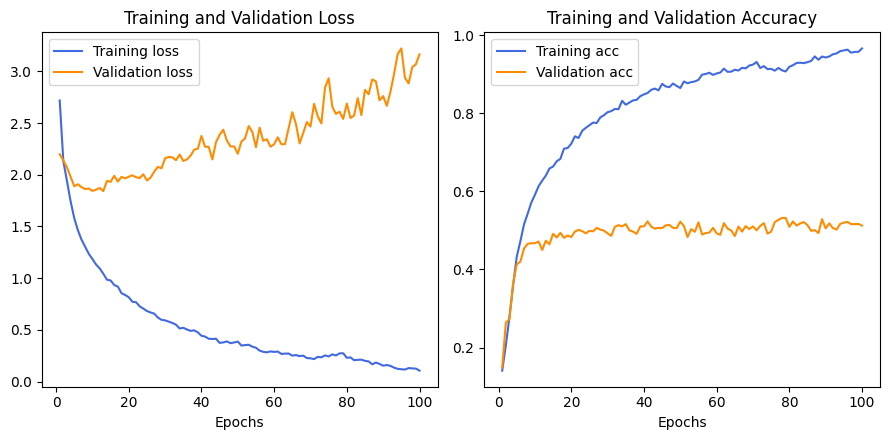

In [ ]:
training_plot(history)

In [ ]:
# Evaluation on the test set
results = model.evaluate(test_256)
print("test loss, test acc:", results)

2/2 [==============================] - 66s 29s/step - loss: 1.6419 - accuracy: 0.6803
test loss, test acc: [1.6418850421905518, 0.6802574992179871]


2/2 [==============================] - 2s 333ms/step


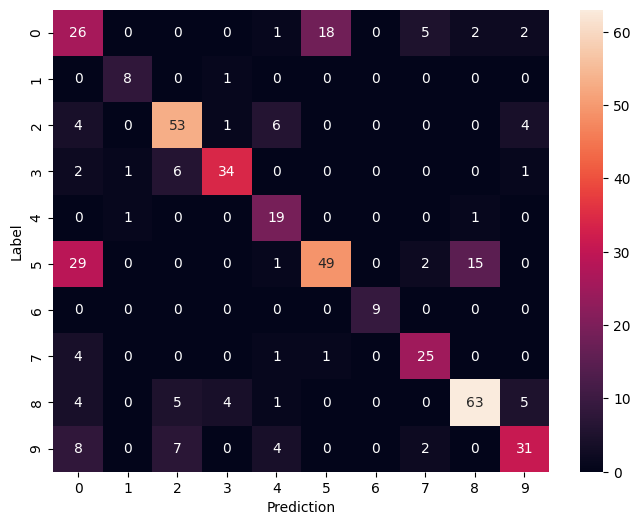

In [ ]:
# Confusion matrix
y_pred = model.predict(test_256)
y_pred = tf.argmax(y_pred, axis=1)

y_true = tf.concat(list(test_256.map(lambda w,lab: lab)), axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
# Save weights of the model
model.save_weights("Transformer_waveforms.h5")

## **3.2) Transformers on stft**

In [ ]:
k = 64 
MAX_SEQ_LENGTH = 126 

inputs = keras.Input(shape=(None, 65))
normalization = layers.Normalization()(inputs)

conv1 = layers.Conv1D(64, 5, activation="elu", padding="same", kernel_initializer='HeNormal')(normalization)
pool1 = layers.MaxPooling1D(pool_size=2)(conv1)

conv2 = layers.Conv1D(64, 10, activation="elu", padding="same", kernel_initializer='HeNormal')(pool1)
pool2 = layers.MaxPooling1D(pool_size=2)(conv2)

position_embeddings = keras_nlp.layers.PositionEmbedding(sequence_length = MAX_SEQ_LENGTH)(pool2)
inter = pool2 + position_embeddings

encoder1 = keras_nlp.layers.TransformerDecoder(intermediate_dim=k, num_heads=8)(inter) 
encoder2 = keras_nlp.layers.TransformerDecoder(intermediate_dim=k, num_heads=8)(encoder1)
global_pool = layers.GlobalMaxPooling1D()(encoder2)
dropout = layers.Dropout(rate=0.3)(global_pool)

outputs = layers.Dense(10)(dropout) 

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, None, 65)]   0           []                               
                                                                                                  
 normalization_7 (Normalization  (None, None, 65)    131         ['input_8[0][0]']                
 )                                                                                                
                                                                                                  
 conv1d_14 (Conv1D)             (None, None, 64)     20864       ['normalization_7[0][0]']        
                                                                                                  
 max_pooling1d_14 (MaxPooling1D  (None, None, 64)    0           ['conv1d_14[0][0]']        

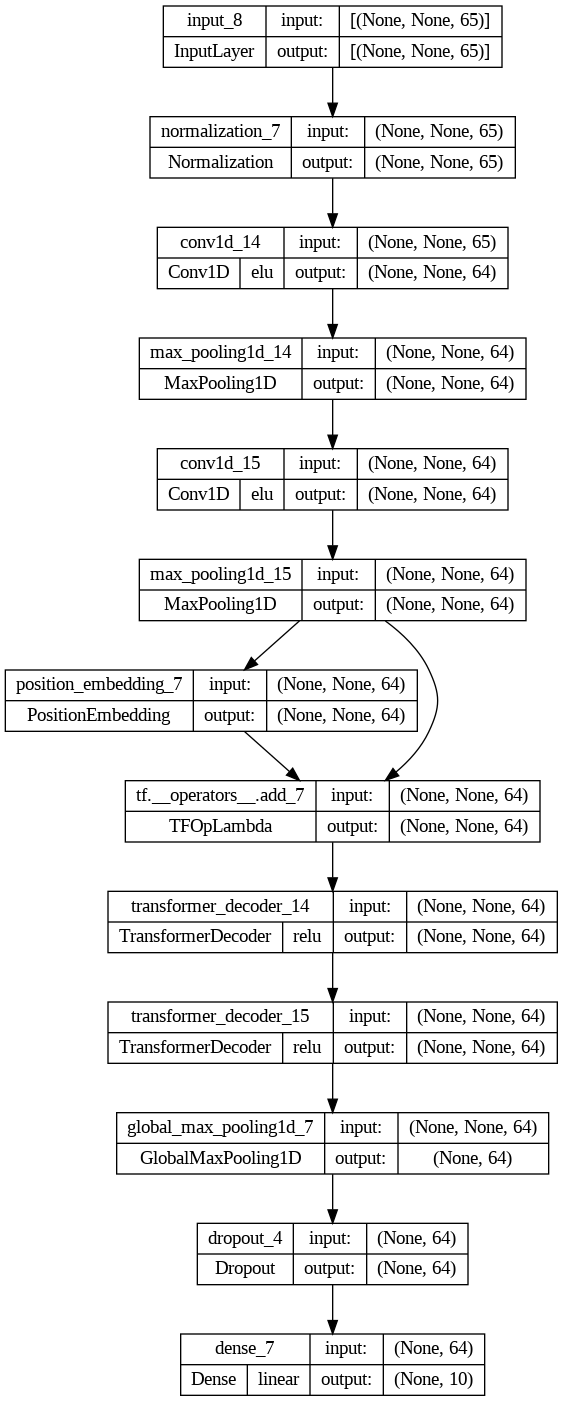

In [ ]:
keras.utils.plot_model(model, 
                       show_shapes=True, 
                       show_layer_activations=True)

Training of the model on 50 epochs -> reach $55\%$ validation accuracy at epoch $30$ and then stabilize on $50\%$ 

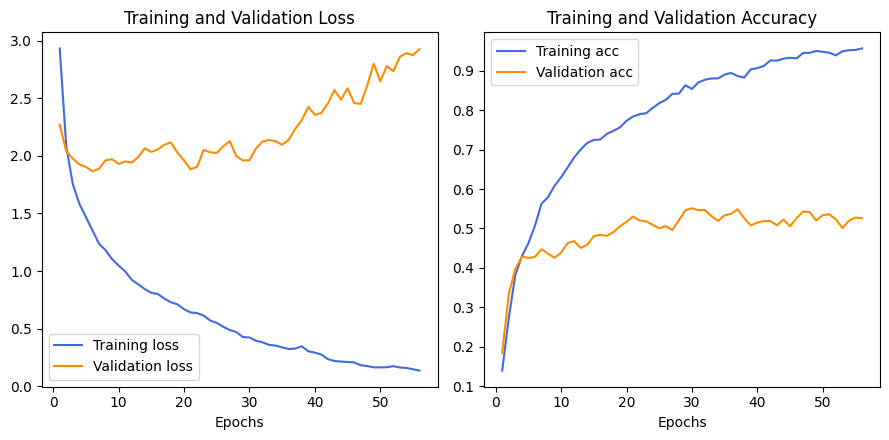

In [ ]:
training_plot(history)

The model is retrained for $30$ epochs

In [ ]:
# Compile the model
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Fit the model
history = model.fit(train_stft_256, 
                    validation_data = val_stft_256, 
                    epochs=30)

Epoch 1/30
25/25 [==============================] - 48s 1s/step - loss: 2.4952 - accuracy: 0.1942 - val_loss: 2.0309 - val_accuracy: 0.3062
Epoch 2/30
25/25 [==============================] - 26s 1s/step - loss: 1.9220 - accuracy: 0.3133 - val_loss: 1.9707 - val_accuracy: 0.3609
Epoch 3/30
25/25 [==============================] - 31s 1s/step - loss: 1.6822 - accuracy: 0.3987 - val_loss: 1.9459 - val_accuracy: 0.3985
Epoch 4/30
25/25 [==============================] - 24s 972ms/step - loss: 1.5650 - accuracy: 0.4416 - val_loss: 1.9313 - val_accuracy: 0.4150
Epoch 5/30
25/25 [==============================] - 24s 956ms/step - loss: 1.4286 - accuracy: 0.4860 - val_loss: 1.9131 - val_accuracy: 0.4297
Epoch 6/30
25/25 [==============================] - 29s 1s/step - loss: 1.3467 - accuracy: 0.5226 - val_loss: 1.9006 - val_accuracy: 0.4398
Epoch 7/30
25/25 [==============================] - 25s 992ms/step - loss: 1.2662 - accuracy: 0.5498 - val_loss: 1.8452 - val_accuracy: 0.4507
Epoch 8/30


In [ ]:
# Evaluation on the test set
results = model.evaluate(test_stft_256)
print("test loss, test acc:", results)

2/2 [==============================] - 3s 938ms/step - loss: 1.1193 - accuracy: 0.7189
test loss, test acc: [1.1192874908447266, 0.7188841104507446]


2/2 [==============================] - 2s 524ms/step


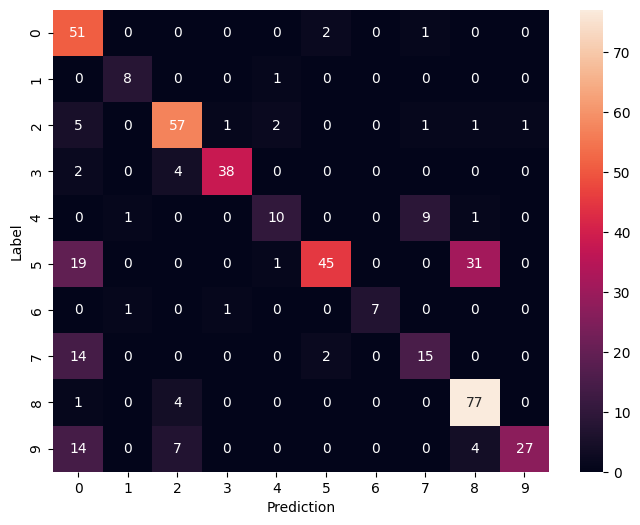

In [ ]:
# Confusion matrix
y_pred = model.predict(test_stft_256)
y_pred = tf.argmax(y_pred, axis=1)

y_true = tf.concat(list(test_stft_256.map(lambda w,lab: lab)), axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
# Save weights of the model
model.save_weights("Transformer_stft.h5")